# 모듈 Import

In [20]:
import cv2 as cv
import sys
import os
from matplotlib import pyplot as plt

import numpy as np
from tensorflow.keras import models, layers, optimizers, utils, Model, regularizers
from keras.utils import np_utils #to_categorical

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score,f1_score,recall_score

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 얼굴 Dataset

In [22]:
path='C:/Users/clari/Desktop/multimodal2/model2/face'

face_images = []
face_labels = []
def crop_images(path, images):
    for img in sorted(os.listdir(path)):
        img_array = cv.imread(os.path.join(path, img))/255
        img_array = cv.resize(img_array, dsize=(0,0), fx=2, fy=2, interpolation=cv.INTER_LINEAR)    
        face_images.append(img_array)
        face_label = np_utils.to_categorical(int(img[:3]), 64)
        face_labels.append(face_label)

crop_images(path, face_images)

In [23]:
face_images = np.array(face_images)
face_labels = np.array(face_labels)

(256, 112, 92, 3)


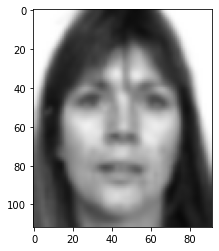

In [24]:
print(face_images.shape)
plt.imshow(face_images[17])

In [200]:
from keras.preprocessing.image import ImageDataGenerator

trainDataGen = ImageDataGenerator(
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 brightness_range=[0.7, 1.3],
                                 horizontal_flip=True,
                                 )

In [25]:
path2='C:/Users/clari/Desktop/multimodal2/model2/aug/face_aug'   #112, 92, 3

In [38]:
i = 0
j = 1
num=4 #레이블 당 개수
im=[]

for img in face_images :
    im.append(img)
    im=np.array(im)
    for batch in trainDataGen.flow(im, batch_size=1, save_to_dir=path2, save_prefix=format(int(i/num),'03'), save_format='png'):
        j += 1
        if j > 7:
            break
    j = 1
    i+=1
    im=[]

In [26]:
def append_images(path, images, labels):
    a=1
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path, img))
        images = np.append(images, [img_array], axis = 0)
        label = np_utils.to_categorical(int(img[:3]), 64)
        labels = np.append(labels, [label], axis=0)
    return images, labels
        
face_images, face_labels = append_images(path2, face_images, face_labels)

KeyboardInterrupt: 

# 홍채 Dataset

In [6]:
path='C:/Users/clari/Desktop/multimodal2/model2/iris'

#786 576
sc=0.3

iris_images = []
iris_labels = []

def img_trim (img):     
    x = 150; y = 90;
    w = 476; h = 430;
    img_trim = img[y:y+h, x:x+w]
    return img_trim

def crop_images(path, images):
    for img in sorted(os.listdir(path)):
      img_array = cv.imread(os.path.join(path, img))/255.0
      img_array = cv.resize(img_trim(img_array), (0,0), fx=sc, fy=sc)
      iris_images.append(img_array)
      iris_label = np_utils.to_categorical(int(img[:3]), 64)
      iris_labels.append(iris_label)
    
crop_images(path, iris_images)

In [7]:
iris_images = np.array(iris_images)
iris_labels = np.array(iris_labels)

(256, 129, 143, 3)


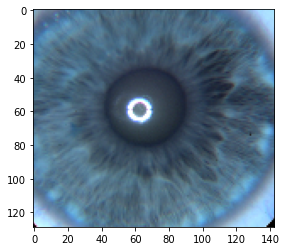

In [8]:
print(iris_images.shape)
plt.imshow(iris_images[0])

In [ ]:
trainDataGen2 = ImageDataGenerator(
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 brightness_range=[0.7, 1.3]
                                # horizontal_flip=True,
                                 )

In [ ]:
path3='C:/Users/clari/Desktop/multimodal2/model2/aug/iris_aug'   #129, 143, 3

In [ ]:
i = 0
j = 1
im=[]
num=4

for img in iris_images :
    im.append(img)
    im=np.array(im)
    for batch in trainDataGen2.flow(im, batch_size=1, save_to_dir=path3, save_prefix=format(int(i/num),'03'), save_format='png'):
        j += 1
        if j > 7:
            break
    j = 1
    i+=1
    im=[]

  

In [ ]:
def append_images(path, images, labels):
    a=1
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path, img))
        images = np.append(images, [img_array], axis = 0)
        label = np_utils.to_categorical(int(img[:3]), 64)
        labels = np.append(labels, [label], axis=0)
    return images, labels

iris_images, iris_labels = append_images(path3, iris_images, iris_labels)

# face 모델 정의

In [ ]:
face_in=layers.Input(shape=(112, 92, 3))

x = face_in
x = layers.Conv2D(filters = 32, kernel_size = (3,3), padding='Same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size = (2,2))(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters = 64, kernel_size = (3,3), padding='Same', activation='relu')(x)
x = layers.AveragePooling2D(pool_size = (2,2))(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters = 128, kernel_size = (3,3), padding='Same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size = (2,2))(x)
x = layers.Dropout(0.1)(x)

x = layers.Flatten()(x)
x = layers.Dense(50, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
face_out = layers.Dense(64, activation='softmax')(x)
face_model = Model(inputs= face_in, outputs=face_out)

face_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# iris 모델

In [ ]:
iris_in=layers.Input(shape=(129, 143, 3))

# 129, 143, 3
# 86, 95, 3
# 43, 48, 3

y=iris_in

y = layers.Conv2D(filters = 32, kernel_size = (3,3), padding='Same', activation='relu')(y)
y = layers.MaxPooling2D(pool_size = (2,2))(y)
y = layers.Dropout(0.1)(y)

y = layers.Conv2D(filters = 32, kernel_size = (3,3), padding='Same', activation='relu')(y)
y = layers.AveragePooling2D(pool_size = (2,2))(y)
y = layers.Dropout(0.1)(y)

y = layers.Conv2D(filters = 64, kernel_size = (3,3), padding='Same', activation='relu')(y)
y = layers.AveragePooling2D(pool_size = (2,2))(y)
y = layers.Dropout(0.1)(y)

y = layers.Conv2D(filters = 128, kernel_size = (3,3), padding='Same', activation='relu')(y)
y = layers.MaxPooling2D(pool_size = (2,2))(y)
y = layers.Dropout(0.1)(y)

y = layers.Flatten()(y)
y = layers.Dense(50, kernel_initializer='he_normal')(y)
y = layers.BatchNormalization()(y)
iris_out = layers.Dense(64, activation='softmax')(y)
iris_model = Model(inputs= iris_in, outputs=iris_out)

iris_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 레이어 병합

In [ ]:
concat = layers.concatenate([face_model.output, iris_model.output])

concat = layers.BatchNormalization()(concat)
concat = layers.Flatten()(concat)
concat = layers.Dense(128, activation='relu')(concat)
concat = layers.Dropout(0.5)(concat)
answer = layers.Dense(64, activation='softmax')(concat)

concat_model = Model(inputs = [face_model.input, iris_model.input], outputs = answer)

concat_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

# 학습

In [18]:
# Split a dataset into k folds
fold_num = 3

def cross_validation_split(X1, X2, Y, folds=fold_num):
    skf = KFold(n_splits= fold_num, shuffle = True)
    skf.get_n_splits(X1, Y)
    dataset_split = []
    i = 0
    for train_index, test_index in skf.split(X1, Y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        train_index = train_index.astype(int)
        test_index = test_index.astype(int)
        X1 = np.array(X1)
        X2 = np.array(X2)
        Y = np.array(Y)
        X_1_train, X_1_test = X1[train_index], X1[test_index]
        X_2_train, X_2_test = X2[train_index], X2[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        k_fold_set = {
                    'k_fold': i,
                    'train': {'X_1': X_1_train, 'X_2': X_2_train, 'Y': y_train},
                    'test': {'X_1': X_1_test, 'X_2': X_2_test, 'Y': y_test}
                    }
        dataset_split.append(k_fold_set)
        i = i + 1

    return dataset_split

result = cross_validation_split(face_images, iris_images, face_labels, folds=fold_num)

In [19]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='loss',     # 모니터 기준 설정 (loss) 
                              patience=10,         # 3회 Epoch동안 개선되지 않는다면 종료
                             )

accs = [];  precision = [];  recall = [];  F1 = []
history = []
i = 0
for k_fold_set in result :
    i += 1    
    print('Fold' + str(i))
    history.append(concat_model.fit([k_fold_set['train']['X_1'], k_fold_set['train']['X_2']], 
                                    k_fold_set['train']['Y'], epochs =50, batch_size = 256, callbacks=earlystopping))
    
    y_test = np.argmax(k_fold_set['test']['Y'], axis = 1)
    pred = np.argmax(concat_model.predict([k_fold_set['test']['X_1'], k_fold_set['test']['X_2']]), axis = 1)

    print(y_test)
    print(pred)
    
    accs.append(accuracy_score(y_test, pred))
    precision.append(precision_score(y_test,pred, average = 'macro'))
    recall.append(recall_score(y_test, pred, average = 'macro',  labels=np.unique(pred)))
    F1.append(f1_score(y_test, pred, average = 'macro',  labels=np.unique(pred)))    

Fold1
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.9616 - accuracy: 0.8594
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.9644 - accuracy: 0.8359
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.7820 - accuracy: 0.8984
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.8376 - accuracy: 0.8828
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.7488 - accuracy: 0.9062
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.6867 - accuracy: 0.8984
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 0.6859 - accuracy: 0.9062
Epoch 8/50
1/1 [==============================] - 3s 3s/step - loss: 0.5954 - accuracy: 0.9453
Epoch 9/50
1/1 [==============================] - 4s 4s/step - loss: 0.5319 - accuracy: 0.9375
Epoch 10/50
1/1 [==============================] - 3s 3s/step - loss: 0.5927 - accuracy: 0.9219
Epoch 11/50
1/1 [==========================

NameError: name 'priny' is not defined

In [230]:
concat_model.summary()

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 129, 143, 3) 0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 129, 143, 32) 896         input_29[0][0]                   
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 112, 92, 3)] 0                                            
__________________________________________________________________________________________________
max_pooling2d_57 (MaxPooling2D) (None, 64, 71, 32)   0           conv2d_97[0][0]                  
___________________________________________________________________________________________

In [ ]:
for i in range(1,fold_num+1):
    print("Fold%d 훈련 결과 : "%i)
    print("     accs : %.6f"%accs[i-1])
    print("     precision : %.6f"%precision[i-1])
    print("     recall : %.6f"%recall[i-1])
    print("     F1 : %.6f"%F1[i-1])

print("\n평균 훈련 결과")
print("     Accuracy : %.6f"%np.mean(accs))
print("     Precision : %.6f"%np.mean(precision))
print("     Recall Score : %.6f"%np.mean(recall))
print("     F1-Score : %.6f"%np.mean(F1))

# 훈련 과정 시각화

In [ ]:
# summarize history for accuracy
plt.plot(history[0].history['accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[3].history['accuracy'])
#plt.plot(history[5].history['accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2','fold3','fold4'], loc=0)
plt.show()

# summarize history for accuracy
plt.plot(history[0].history['loss'])
plt.plot(history[1].history['loss'])
plt.plot(history[2].history['loss'])
plt.plot(history[3].history['loss'])
#plt.plot(history[5].history['loss'])
plt.title('model train accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2','fold3','fold4'], loc='upper left')
plt.show()


# 테스트 데이터셋 예측

In [227]:
path='C:/Users/clari/Desktop/multimodal2/model2/face_test'

test_num = []
face_test_images = []
def crop_test_images(path, images):
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path, img))/255.0
        img_array = cv.resize(img_array, dsize=(0,0), fx=2, fy=2, interpolation=cv.INTER_LINEAR)          
        face_test_images.append(img_array)
        test_num.append(int(img[:2]))

crop_test_images(path, face_test_images)

In [228]:
path2='C:/Users/clari/Desktop/multimodal2/model2/iris_test'

iris_test_images = []
def crop_test_images2(path, test_images):
    for img in os.listdir(path):
      img_array = cv.imread(os.path.join(path, img))/255.0
      img_array = cv.resize(img_trim(img_array), (0,0), fx=sc, fy=sc) 
      iris_test_images.append(img_array)

crop_test_images2(path2, iris_test_images)

In [229]:
face_test_images = np.array(face_test_images)
iris_test_images = np.array(iris_test_images)
test_num = np.array(test_num)

In [160]:
import pandas as pd

pred = np.argmax(concat_model.predict([face_test_images,iris_test_images]), axis=1)

df = pd.DataFrame({'Image': test_num, 'Answer': pred}).sort_values('Image')
df.to_csv('C:/Users/clari/Desktop/multimodal2/model2/1871081_이희연_멀티모달_모델2개2.csv', index = False)